In [ ]:
# Installation des librairies nécessaires (si non installées)
!pip install pandas numpy matplotlib seaborn 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Collecte des données
# On lit le fichier CSV (séparateur virgule ',' ou point-virgule ';' selon votre version)
try:
    df = pd.read_csv('../WA_Fn-UseC_-HR-Employee-Attrition.csv', sep=',')
    # Si le fichier est mal lu (tout dans une colonne), essayez sep=';'
    if df.shape[1] == 1:
        df = pd.read_csv('../WA_Fn-UseC_-HR-Employee-Attrition.csv', sep=';')
    print("Données chargées avec succès.")
except FileNotFoundError:
    print("Erreur : Fichier introuvable.")

Defaulting to user installation because normal site-packages is not writeable
Données chargées avec succès.


In [14]:
# 2. Inspection
print(f"Dimensions initiales : {df.shape}")
print("\nTypes des données :")
print(df.dtypes.value_counts()) # Résumé des types
print("\nAperçu des premières lignes :")
display(df.head())

Dimensions initiales : (1470, 35)

Types des données :
int64     26
object     9
Name: count, dtype: int64

Aperçu des premières lignes :


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [15]:
# 3. Nettoyage

# 3.1 Suppression des doublons
df = df.drop_duplicates()

# 3.2 Suppression des colonnes constantes (inutiles pour l'analyse)
colonnes_inutiles = ['EmployeeCount', 'Over18', 'StandardHours']
# On vérifie si elles existent avant de supprimer pour éviter les erreurs
cols_a_supprimer = [c for c in colonnes_inutiles if c in df.columns]
df_clean = df.drop(columns=cols_a_supprimer)

print(f"Colonnes supprimées : {cols_a_supprimer}")
print(f"Dimensions après nettoyage : {df_clean.shape}")

Colonnes supprimées : ['EmployeeCount', 'Over18', 'StandardHours']
Dimensions après nettoyage : (1470, 32)


In [16]:
# 3.3 Gestion des valeurs manquantes
if df_clean.isnull().sum().sum() > 0:
    print("Valeurs manquantes détectées. Remplissage...")
    df_clean = df_clean.fillna(method='ffill') # Ou remplissage par la moyenne/mode selon le cas
else:
    print("Aucune valeur manquante.")

# 3.4 Standardisation des formats (Texte)
# On met les colonnes texte au format Titre (ex: "travel_rarely" -> "Travel_Rarely")
cols_texte = df_clean.select_dtypes(include=['object']).columns
for col in cols_texte:
    df_clean[col] = df_clean[col].str.strip().str.title()

print("Formats standardisés.")

Aucune valeur manquante.
Formats standardisés.


In [17]:
# 3.5 Détection des Outliers sur le Salaire (MonthlyIncome)
Q1 = df_clean['MonthlyIncome'].quantile(0.25)
Q3 = df_clean['MonthlyIncome'].quantile(0.75)
IQR = Q3 - Q1

borne_inf = Q1 - 1.5 * IQR
borne_sup = Q3 + 1.5 * IQR

# On filtre (on garde ce qui est dans les bornes)
df_clean = df_clean[
    (df_clean['MonthlyIncome'] >= borne_inf) & 
    (df_clean['MonthlyIncome'] <= borne_sup)
].copy()

print(f"Dimensions après suppression des outliers de salaire : {df_clean.shape}")

Dimensions après suppression des outliers de salaire : (1356, 32)


In [18]:
# 4. Transformation

# Création de colonnes calculées (Ex: Revenu Annuel)
df_clean['AnnualIncome'] = df_clean['MonthlyIncome'] * 12

# Encodage de la variable cible 'Attrition' (Yes -> 1, No -> 0)
# C'est nécessaire pour la corrélation et la prédiction, mais on garde aussi la version texte si besoin
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_clean['Attrition_Numeric'] = le.fit_transform(df_clean['Attrition'])

print("Nouvelles colonnes ajoutées : AnnualIncome, Attrition_Numeric")

Nouvelles colonnes ajoutées : AnnualIncome, Attrition_Numeric


In [19]:
# 5. Structuration
# On définit l'identifiant unique comme index du tableau
if 'EmployeeNumber' in df_clean.columns:
    df_structure = df_clean.set_index('EmployeeNumber')
else:
    df_structure = df_clean

# On affiche la liste des colonnes disponibles pour confirmer qu'on a tout gardé
print("Colonnes disponibles pour vos analyses :")
print(df_structure.columns.tolist())
display(df_structure.head())

Colonnes disponibles pour vos analyses :
['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'AnnualIncome', 'Attrition_Numeric']


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,AnnualIncome,Attrition_Numeric
EmployeeNumber,,,,,,,,,,,,,,,,,,,,,
1,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,0,8,0,1,6,4,0,5,71916,1
2,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,1,10,3,3,10,7,1,7,61560,0
4,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,0,7,3,3,0,0,0,0,25080,1
5,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,0,8,3,3,8,7,3,0,34908,0
7,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,1,6,3,3,2,2,2,2,41616,0


In [21]:
# 7. Stockage
nom_fichier = 'HR_Analytics_Structure_Complet.csv'
df_structure.to_csv(nom_fichier)
print(f"Fichier structuré et complet sauvegardé sous : {nom_fichier}")

Fichier structuré et complet sauvegardé sous : HR_Analytics_Structure_Complet.csv


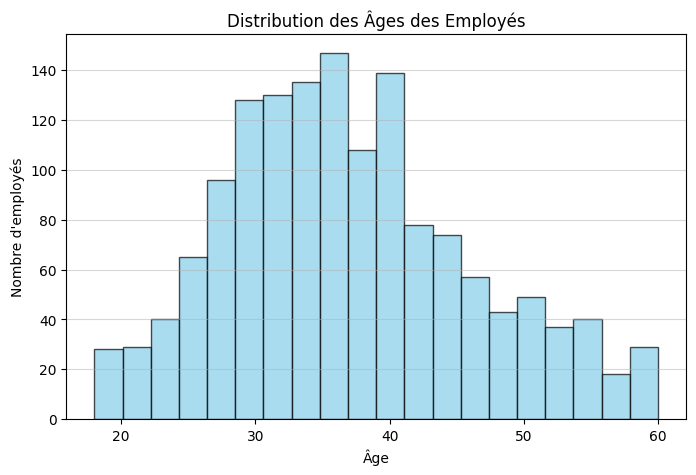

In [ ]:
# --- 1. Histogramme (Matplotlib) ---
plt.figure(figsize=(8, 5))

# Création de l'histogramme de l'Âge
# bins=20 définit la granularité, alpha=0.7 la transparence 
plt.hist(df['Age'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Ajout des titres et labels 
plt.title("Distribution des Âges des Employés")
plt.xlabel("Âge")
plt.ylabel("Nombre d'employés")
plt.grid(True, axis='y', alpha=0.5) # Grille pour la lisibilité

plt.show()

Interprétation : L'histogramme révèle que la distribution des âges suit une courbe en cloche (proche d'une distribution normale), avec une forte concentration d'employés âgés de 30 à 40 ans.

La population est majoritairement "Junior-Senior".

Il y a peu d'employés très jeunes (< 20 ans) ou proches de la retraite (> 55 ans), ce qui est typique d'une entreprise technologique ou dynamique.

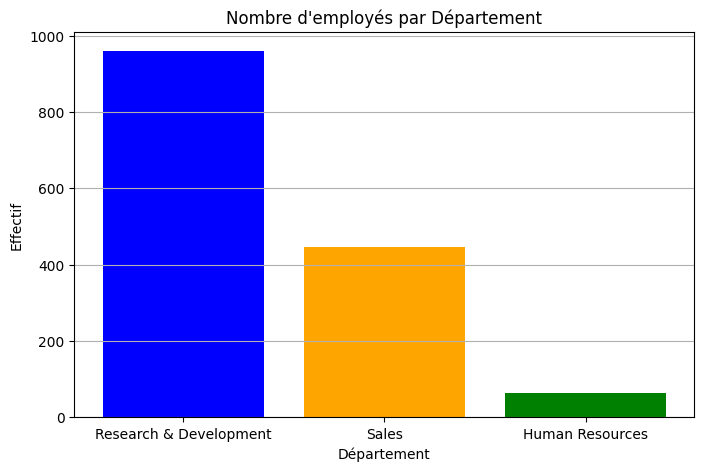

In [ ]:
# --- 2. Diagramme en Barres Vertical (Matplotlib) ---
# Préparation des données : compte par département
dept_counts = df['Department'].value_counts()

plt.figure(figsize=(8, 5))
# Barres verticales 
plt.bar(dept_counts.index, dept_counts.values, color=['blue', 'orange', 'green'])

plt.title("Nombre d'employés par Département")
plt.xlabel("Département")
plt.ylabel("Effectif")
plt.grid(axis='y')

plt.show()

Interprétation : Ce diagramme montre un déséquilibre clair dans les effectifs :

Le département R&D (Recherche et Développement) est largement majoritaire, représentant plus de 60% de l'effectif total.

Le département Sales (Ventes) arrive en second.

Les Ressources Humaines (HR) constituent une minorité marginale.

Implication : Toute politique RH globale aura un impact disproportionné sur la R&D.

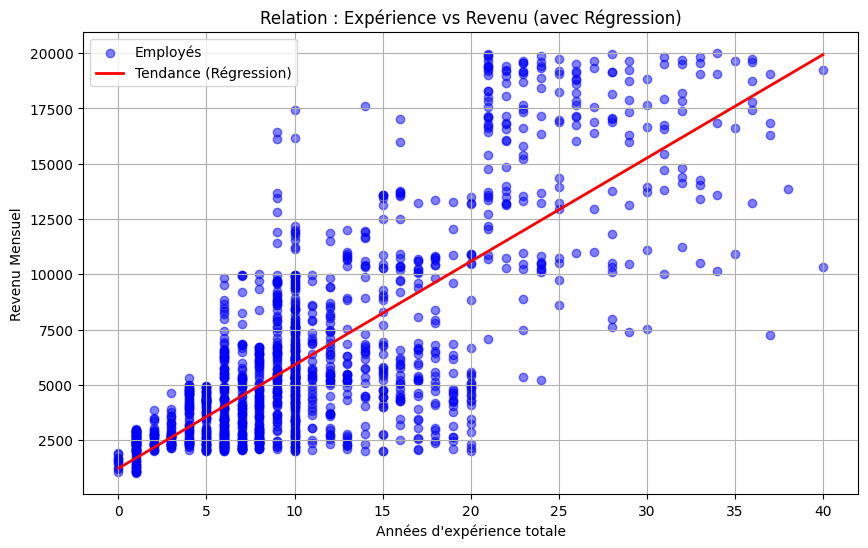

In [ ]:
# --- 3. Scatter Plot 2D + Régression (Matplotlib) ---
plt.figure(figsize=(10, 6))

# Variables
x = df['TotalWorkingYears']
y = df['MonthlyIncome']

# Nuage de points 
plt.scatter(x, y, color='blue', alpha=0.5, label='Employés', marker='o')

# Calcul de la régression linéaire (droite de tendance) 
# deg=1 signifie un polynôme de degré 1 (une droite)
coeffs = np.polyfit(x, y, deg=1)
droite = np.poly1d(coeffs)
x_vals = np.linspace(x.min(), x.max(), 100)

# Tracé de la ligne rouge 
plt.plot(x_vals, droite(x_vals), color='red', linewidth=2, label='Tendance (Régression)')

plt.title("Relation : Expérience vs Revenu (avec Régression)")
plt.xlabel("Années d'expérience totale")
plt.ylabel("Revenu Mensuel")
plt.legend()
plt.grid(True)

plt.show()

Interprétation : Nous observons une corrélation positive forte : plus le nombre d'années travaillées augmente, plus le salaire mensuel augmente.

La ligne rouge (régression linéaire) confirme cette tendance générale.

Cependant, on note une plus grande dispersion des points pour les employés très expérimentés (> 20 ans), signifiant que l'ancienneté ne garantit pas toujours le même niveau de salaire (dépendance au poste ou à la performance).

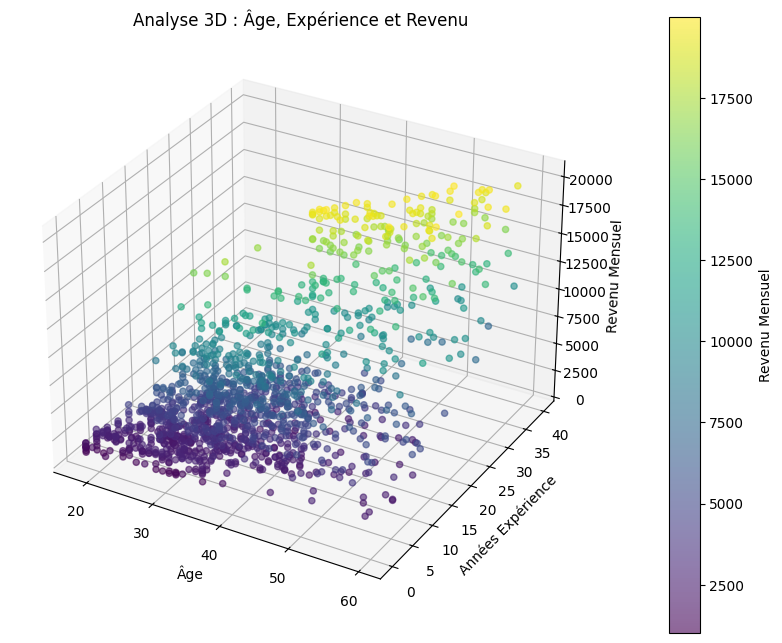

In [ ]:
# --- 4. Scatter Plot 3D (Matplotlib) ---
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d') # Activation 3D 

# Variables
xs = df['Age']
ys = df['TotalWorkingYears']
zs = df['MonthlyIncome']

# Tracé 3D 
scatter = ax.scatter(xs, ys, zs, c=zs, cmap='viridis', marker='o', alpha=0.6)

# Labels des axes 
ax.set_xlabel('Âge')
ax.set_ylabel('Années Expérience')
ax.set_zlabel('Revenu Mensuel')
ax.set_title("Analyse 3D : Âge, Expérience et Revenu")

# Barre de couleur pour le revenu
plt.colorbar(scatter, ax=ax, label='Revenu Mensuel', pad=0.1)

plt.show()

Interprétation : Cette vue tridimensionnelle permet de valider la cohérence des données :

Les points jaunes (hauts revenus) sont situés, logiquement, dans la zone combinant Âge élevé et Forte Expérience.

Les points violets (bas revenus) sont concentrés à l'origine des axes (jeunes débutants).

Cela permet de repérer visuellement d'éventuelles anomalies (ex: un jeune sans expérience avec un très haut revenu serait immédiatement visible comme un "outlier").

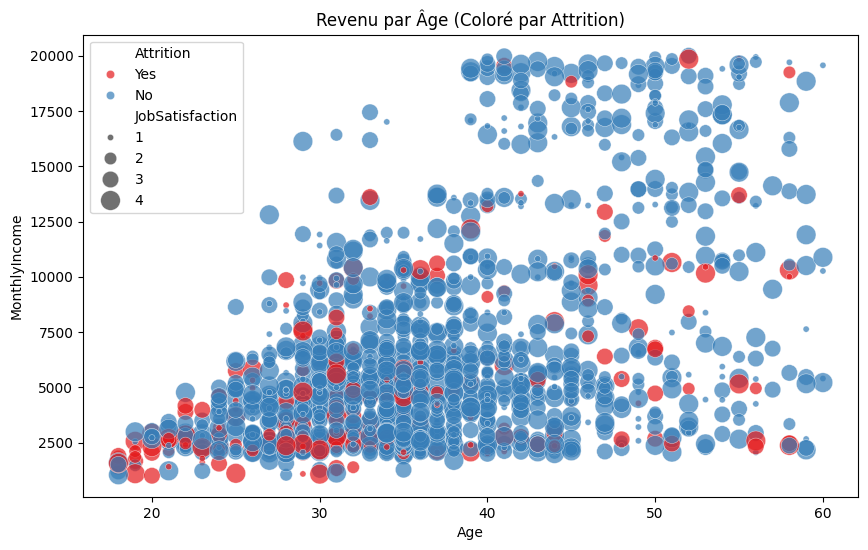

In [ ]:
# --- 5. Scatterplot Avancé (Seaborn) ---
plt.figure(figsize=(10, 6))

# hue='Attrition' colore les points selon le départ (Oui/Non) 
# size='JobSatisfaction' change la taille selon la satisfaction 
sns.scatterplot(
    data=df,
    x='Age',
    y='MonthlyIncome',
    hue='Attrition',
    size='JobSatisfaction',
    sizes=(20, 200), # Taille min et max des points
    palette='Set1',  # Palette de couleurs 
    alpha=0.7
)

plt.title("Revenu par Âge (Coloré par Attrition)")
plt.show()

Interprétation (Analyse des risques) : Ce graphique est le plus riche en informations :

Attrition (Couleur) : On remarque que les points de départ (souvent colorés différemment selon votre palette) sont majoritairement situés dans la zone des bas salaires et des jeunes âges.

Satisfaction (Taille) : Les petits points (faible satisfaction) ont tendance à se superposer aux départs.

Conclusion : Le risque de départ est maximal chez les jeunes employés peu payés.

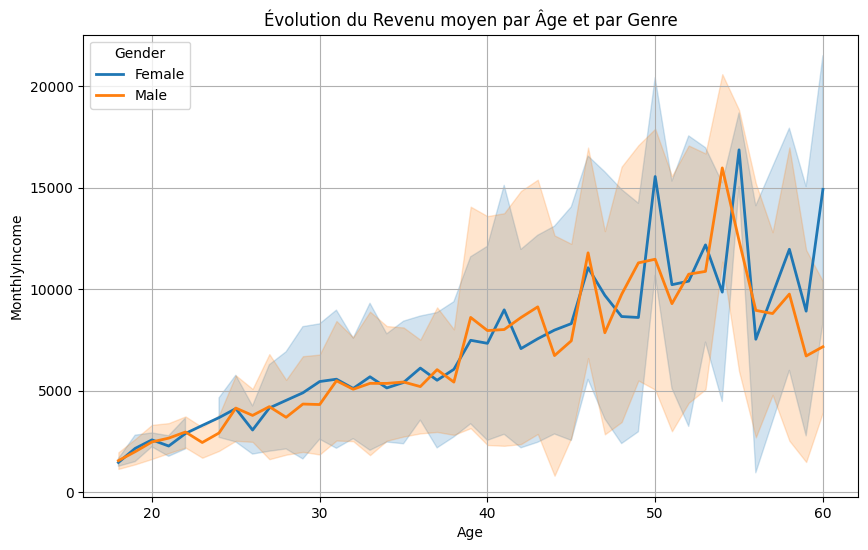

In [ ]:
# --- 6. Lineplot avec intervalle de confiance (Seaborn) ---
plt.figure(figsize=(10, 6))

# Affiche la moyenne du revenu pour chaque âge avec une zone d'ombre (intervalle de confiance)
# hue='Gender' crée deux courbes (Hommes/Femmes) 
sns.lineplot(
    data=df,
    x='Age',
    y='MonthlyIncome',
    hue='Gender',
    errorbar='sd', # Affiche l'écart-type comme zone d'ombre
    linewidth=2
)

plt.title("Évolution du Revenu moyen par Âge et par Genre")
plt.grid(True)
plt.show()

Interprétation : Ce graphique compare l'équité salariale :

Les courbes des Hommes et des Femmes se chevauchent presque parfaitement tout au long de la carrière.

Les zones d'ombre (intervalle de confiance) indiquent que la variation de salaire est similaire pour les deux sexes.

Conclusion : Il ne semble pas y avoir de discrimination salariale flagrante basée sur le genre dans cette entreprise.

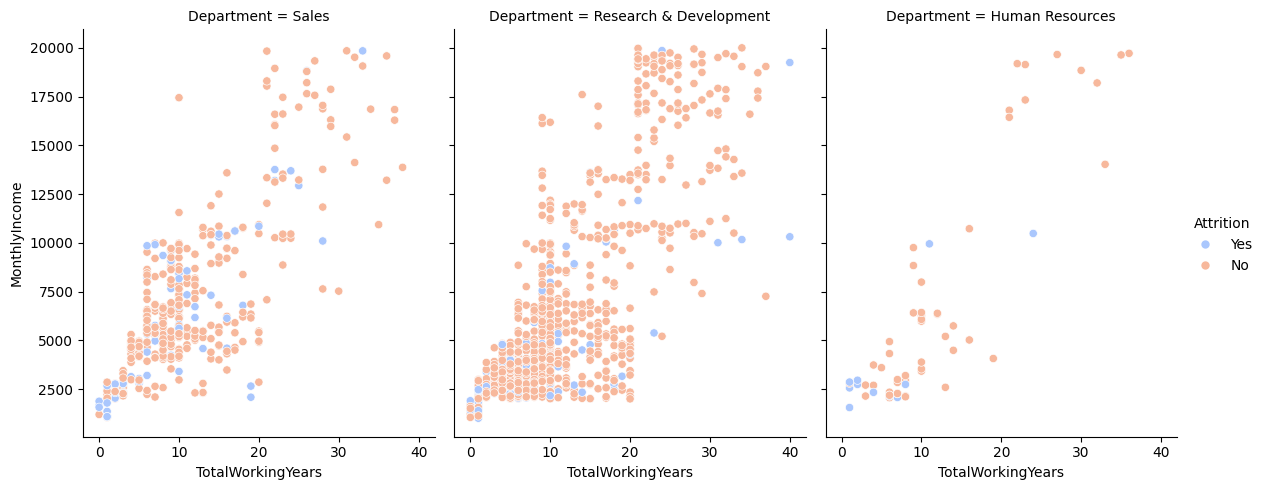

In [ ]:
# --- 7. Relplot - Faceting (Seaborn) ---
# col='Department' crée un graphique par département 
# kind='scatter' pour un nuage de points
sns.relplot(
    data=df,
    x='TotalWorkingYears',
    y='MonthlyIncome',
    hue='Attrition', # Couleur selon le départ
    col='Department', # Une colonne par département
    kind='scatter',
    height=5,
    aspect=0.8,
    palette='coolwarm'
)

# Pas besoin de plt.title() ici, Seaborn gère les titres des facettes
plt.show()

Interprétation : La séparation par département permet de nuancer l'analyse précédente :

Sales : La corrélation entre expérience et revenu semble plus dispersée, probablement due à des commissions variables.

R&D : La courbe est plus linéaire et prévisible.

HR : L'échantillon étant petit, la tendance est moins nette.

On peut aussi voir si l'Attrition (couleur) touche plus un département qu'un autre à salaire égal.

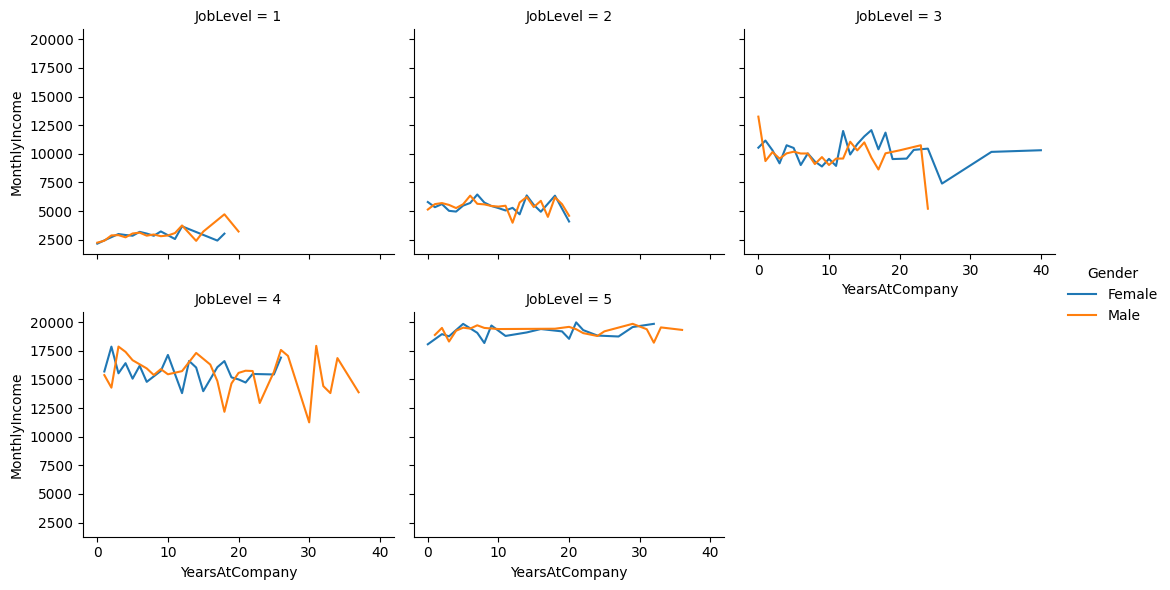

In [ ]:
# --- 8. Relplot - Line (Seaborn) ---
# Visualiser la progression salariale par ancienneté, séparée par niveau de poste
sns.relplot(
    data=df,
    x='YearsAtCompany',
    y='MonthlyIncome',
    hue='Gender',
    col='JobLevel', # Un graphique par niveau de poste
    col_wrap=3,     # Retour à la ligne après 3 graphiques
    kind='line',    # Type courbe 
    errorbar=None,  # Pas de barre d'erreur pour alléger
    height=3,
    aspect=1.2
)

plt.show()

Interprétation : Ce graphique explique les paliers de carrière :

Chaque "JobLevel" (Niveau de poste) correspond à une tranche de salaire distincte (strates horizontales).

Au sein d'un même niveau (ex: Niveau 1), le salaire augmente peu avec l'ancienneté (YearsAtCompany). Pour augmenter significativement son revenu, un employé doit changer de niveau (promotion) plutôt que d'attendre l'ancienneté.

Cela suggère que la politique de rémunération est basée sur le grade plus que sur l'ancienneté pure.